Урок 9. Python применение продвинутых методов

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats import proportion
#from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.power as smp

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Задание 1
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats

In [2]:
df = pd.read_excel('ab_testing_hw9.xlsx')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df["userid"].nunique()

90189

In [6]:
df[['sum_gamerounds', 'retention_1', 'retention_7']].describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


Уберем аномальный выброс в поле sum_gamerounds

In [7]:
df = df[df['sum_gamerounds'] < 49000]

In [8]:
df['version'].value_counts()

version
gate_40    45489
gate_30    44699
Name: count, dtype: int64

In [9]:
df['retention_1'].value_counts()

retention_1
0    50035
1    40153
Name: count, dtype: int64

In [10]:
df['retention_7'].value_counts()

retention_7
0    73408
1    16780
Name: count, dtype: int64

In [11]:
df.groupby('version').agg({'userid': 'count', 'retention_1': 'mean', 'retention_7': 'mean', 'sum_gamerounds': sum})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44699,0.448198,0.190183,2294941
gate_40,45489,0.442283,0.182000,2333530


анализ:
1) пустых данных нет
2) количество пользователей примерно одинаковое
3) в данных ошибок нет

Проверим данные на нормальность

In [12]:
A = df.query('version == "gate_30"')
B = df.query('version == "gate_40"')
n1, n2 = A.shape[0], B.shape[0]

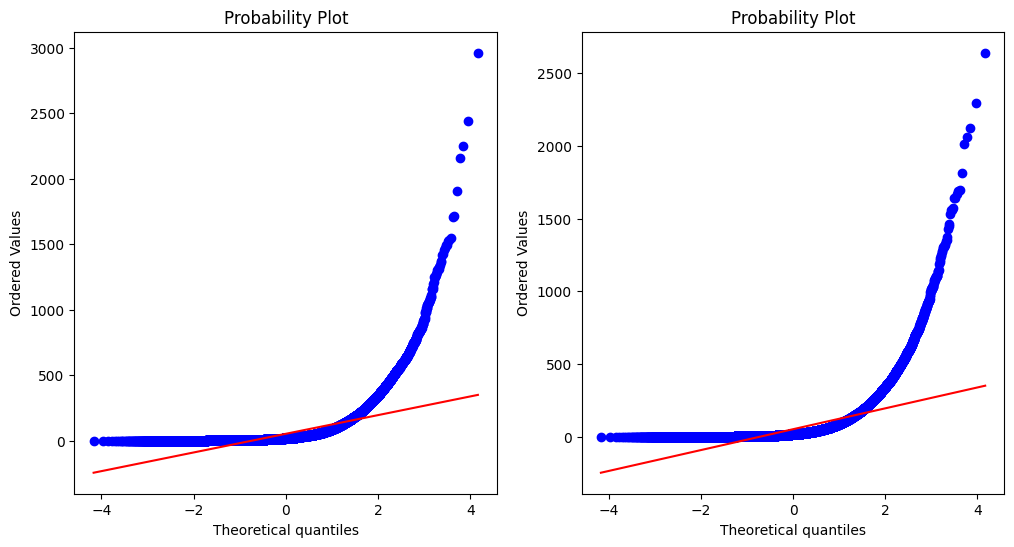

In [13]:
plt.figure(figsize = [6*2, 6])

plt.subplot(1, 2, 1)
norm = stats.probplot(A['sum_gamerounds'], dist="norm", plot=plt)

plt.subplot(1, 2, 2)
norm = stats.probplot(B['sum_gamerounds'], dist="norm", plot=plt)

In [14]:
stats.kstest(A['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)

так как p-value < 0,005 то распределение не нормальное

In [15]:
stats.kstest(B['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)

так как p-value < 0,005 то распределение не нормальное

Испльзуем критерий Манна-Уитни

In [16]:
stats.mannwhitneyu(x=A['sum_gamerounds'].values,
                   y=B['sum_gamerounds'].values)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

так как p-value < 0,005 то принимаем нулевую гепотизу